# Feature engineering
## Setup

In [16]:
# Loading packages and their components
import pandas as pd
import numpy as np
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
pd.options.display.max_columns = None

In [18]:
# Load data
data_subsets_splitted_joined = pickle.load(open('splitted_joined_data.pickle', 'rb'))

sj_train_train, \
sj_train_test, \
sj_test, \
iq_train_train, \
iq_train_test, \
iq_test = data_subsets_splitted_joined

---
## Features based on temperature functions 
The vital rates of mosquitos (main vector of dengue: Ae. aegypti) respond strongly and nonlinearly to temperature and therefore to climate change. We extracted the temperature dependent fuctions from the paper *"Thermal biology of mosquito-borne disease"* ([Mordecai et al. 2019](https://onlinelibrary.wiley.com/doi/full/10.1111/ele.13335)). All selected functions describe the temperature dependency of the main dengue vector *Ae. aegypti* (in context with dengue transmission).
* `biting_rate` for the biting rate
* `fecundity` for fecundity (measured as eggs per female per day)
* `mdr`for mosquito development rate (MDR)
* `immature_survival`for survival of immature stages (eggs, larvae and pupae)
* `lifespan` for mosquito lifespan 
* `transmission_probability` for the probability of transmission
* `infection_probability` for the probability of infection
* `pdr`for parasite development rate (PDR)

Setup of the two basic functions:
$$Briere: q T(T-Tmin)(Tmax-T)^{1/2}$$
$$Quadratic: -q(T-Tmin)(T-Tmax)$$

In [19]:
# briere function: q*T*[T-Tmin]*[Tmax-T]^(1/2)
def briere_function(q, T, Tmin, Tmax):
    return (q*T*(T-Tmin)*(Tmax-T)**(1/2))

# quadratic function: -q*[T-Tmin]*[T-Tmax]^(1/2)
def quadratic_function(q, T, Tmin, Tmax):
    return (-q*(T-Tmin)*(T-Tmax))

Apply the basic functions with specific parameters from the above mentioned paper for the eight different functions.

In [20]:
# biting rate
def biting_rate(T):
    return briere_function(q=(2.02*(10**(-4))), T=T, Tmin=13.8, Tmax=40.0)

# fecundity
def fecundity(T):
    return briere_function(q=(8.16*(10**(-3))), T=T, Tmin=14.7, Tmax=34.4)

# Mosquito Dev. Rate (MDR)
def mdr(T):
    return briere_function(q=(7.83*(10**(-5))), T=T, Tmin=11.6, Tmax=39.1)

# immature_survival
def immature_survival(T):
    return quadratic_function(q=(5.99*(10**(-3))), T=T, Tmin=13.6, Tmax=38.3)

# lifespan
def lifespan(T):
    return quadratic_function(q=(1.44*(10**(-1))), T=T, Tmin=9, Tmax=37.7)

# transmission probability (A. aegypti)
def transmission_probability(T):
    return briere_function(q=(8.33*(10**(-4))), T=T, Tmin=17.2, Tmax=35.8)

# infection probability (A. aegypti)
def infection_probability(T):
    return briere_function(q=(4.88*(10**(-4))), T=T, Tmin=12.7, Tmax=37.4)

# Mosquito Dev. Rate (MDR) 
def pdr(T):
    return briere_function(q=(6.13*(10**(-5))), T=T, Tmin=10.3, Tmax=45.6)

---
#### For visualization: Plot the graphs of the different functions
For illustration the graphs of the different functions within the range of 5 - 50 °C are plotted.

In [41]:
# get the the results of the different functions for T from 5°C to 50°C 
biting_rate_plot = [biting_rate(i) for i in range(5, 51)]
biting_rate_plot = pd.Series(biting_rate_plot).clip(lower=0)

fecundity_plot_raw = [fecundity(i) for i in range(5, 51)]
fecundity_plot_raw = pd.Series(fecundity_plot_raw).clip(lower=0)
fecundity_plot = [i/fecundity_plot_raw.max() for i in fecundity_plot_raw]

mdr_plot = [mdr(i) for i in range(5, 51)]
mdr_plot = pd.Series(mdr_plot).clip(lower=0)

immature_survival_plot = [immature_survival(i) for i in range(5, 51)]
immature_survival_plot = pd.Series(immature_survival_plot).clip(lower=0)

lifespan_plot_raw = [lifespan(i) for i in range(5, 51)]
lifespan_plot_raw = pd.Series(lifespan_plot_raw).clip(lower=0)
lifespan_plot = [i/lifespan_plot_raw.max() for i in lifespan_plot_raw]

transmission_aegypti_plot = [transmission_probability(i) for i in range(5, 51)]
transmission_aegypti_plot = pd.Series(transmission_aegypti_plot).clip(lower=0)

infection_aegypti_plot = [infection_probability(i) for i in range(5, 51)]
infection_aegypti_plot = pd.Series(infection_aegypti_plot).clip(lower=0)

pdr_plot = [pdr(i) for i in range(5, 51)]
pdr_plot = pd.Series(pdr_plot).clip(lower=0)

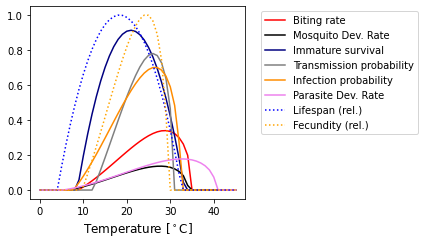

In [43]:
# plot all max<1 together
fig, ax = plt.subplots(figsize=(6, 3.5), tight_layout=True)

ax.plot(biting_rate_plot, color='red');
ax.plot(mdr_plot, color='black');
ax.plot(immature_survival_plot, color='navy');
ax.plot(transmission_aegypti_plot, color='gray');
ax.plot(infection_aegypti_plot, color='darkorange');
ax.plot(pdr_plot, color='violet');
ax.plot(lifespan_plot, color='blue', linestyle=':');
ax.plot(fecundity_plot, color='orange', linestyle=':');

ax.set_ylabel('')
ax.set_xlabel(r'Temperature [$^\circ$C]', fontsize=12)
ax.tick_params(labelsize=10)
ax.legend(labels=['Biting rate', 'Mosquito Dev. Rate', 'Immature survival', 'Transmission probability', 
                  'Infection probability', 'Parasite Dev. Rate', 'Lifespan (rel.)', 'Fecundity (rel.)'], fontsize=10,
             bbox_to_anchor=(1.05, 1), loc='upper left')

fig.savefig('plots/T_functions.png', facecolor='white', dpi=300)

---

In [6]:
def get_temperature_features(data_set, t_feat='reanalysis_air_temp_c'):
    """
    Applies the different functions of a temperature variable on each dataframe in a dataset.
    
    ----------
    Parameters
    
    data_set: list of dataframe
    t_feat: string, column name of a temperature variable, the temperature functions should be applied on 
    """
    for i in range(len(data_set)):
        data_set[i] = (
            data_set[i]
            .assign(biting_rate = lambda x: biting_rate(x[t_feat]))
            .assign(fecundity = lambda x: fecundity(x[t_feat]))
            .assign(mdr = lambda x: mdr(x[t_feat]))
            .assign(immature_survival = lambda x: immature_survival(x[t_feat]))
            .assign(lifespan = lambda x: lifespan(x[t_feat]))
            .assign(transmission_probability = lambda x: transmission_probability(x[t_feat]))
            .assign(infection_probability = lambda x: infection_probability(x[t_feat]))
            .assign(pdr = lambda x: pdr(x[t_feat])) 
        )
    return data_set

In [7]:
# apply function on data_subsets_splitted_joined to get temperature variables 
data_subsets_feat = get_temperature_features(data_subsets_splitted_joined)

## Get cumulative precipitation variable
Get a variables which describe the cumulative precipitation within the last two to six weeks. 
* `cum_precip_2w` for cumulative precipitation within the last two weeks
* `cum_precip_3w` for cumulative precipitation within the last three weeks.
* `cum_precip_4w` for cumulative precipitation within the last four weeks.
* `cum_precip_5w` for cumulative precipitation within the last five weeks.
* `cum_precip_6w` for cumulative precipitation within the last six weeks.

In [8]:
def get_cumulative_precip(data_set, precip_feat='station_precip_mm'):
    """
    Applies the different functions to get the cumulative precipitation for certain phases on each dataframe in a dataset.
    
    ----------
    Parameters
    
    data_set: list of dataframe
    precip_feat: string, column name of a precipitation variable, 
            the cumulative precipitation values should be based on 
    """
    for i in range(len(data_set)):
        data_set[i] = (
            data_set[i]
            .assign(cum_precip_2w = lambda x: x[precip_feat].rolling(2).sum())
            .assign(cum_precip_3w = lambda x: x[precip_feat].rolling(3).sum())
            .assign(cum_precip_4w = lambda x: x[precip_feat].rolling(4).sum())
            .assign(cum_precip_5w = lambda x: x[precip_feat].rolling(5).sum())
            .assign(cum_precip_6w = lambda x: x[precip_feat].rolling(6).sum())
        )
    return data_set

In [9]:
# apply function on data_subsets_splitted_joined to get temperature variables 
data_subsets_feat = get_cumulative_precip(data_subsets_feat)

### Save feature engineered data subsets

In [10]:
# save the gc_lagged data subsets in a pickle
pickle.dump(data_subsets_feat, open('data_subsets_features.pickle', 'wb'))

In [11]:
# FOR LOADING
#data_subsets_features = pickle.load(open('data_subsets_features.pickle', 'rb'))

#sj_train_train_feat, \
#sj_train_test_feat, \
#iq_train_train_feat, \
#iq_train_test_feat = data_subsets_features

---
## Adding lagged values
For predictive modeling the previous values (lagged by a certain time interval) of certain variables are needed. Therefore, variables with the values from a previous phase / shifted values are included. They are denoted as the original feature name with a added `_lagX`, while the X is the number of the lag.

In [12]:
def env_cols(df):
    '''
    Returns a list of only environmental variables (that can be lagged).
    '''
    cols = df.columns.to_list()
    unwanted = ['week_start_date',
                'city',
                'year',
                'weekofyear',
                'month',
                'total_cases',
                'total_cases_o_seas',
                'total_cases_wo_seas'
               ]
    return [e for e in cols if e not in unwanted]

In [13]:
def get_lagged_dataframe(df, features, max_lag):
    """
    Creates new dataframe with certain lagged features as columns. 
    Number of lags (defined by max_lag) start at 1.
    ----------
    Parameters
    
    df: dataframe, which contains features and with time as index
    features: list, of feature names
    max_lag: number of maximum lags
    
    """
    d = {}
    for feature in features:
        for lag in range(1, max_lag+1):
            l = []
            for r in range(len(df)):
                l.append(df.shift(lag)[feature][r])
            d[f'{feature}_lag{lag}'] = l
    lagged_df = pd.DataFrame.from_dict(d)
    lagged_df.index = df.index
    # delete '_lag0'
    return lagged_df

In [14]:
def apply_lagged(data_set, lags=8):
    data_set_output = []
    for i in range(len(data_set)):
        data_set_output.append(get_lagged_dataframe(data_set[i], env_cols(data_set[i]), lags))
    return data_set_output

In [15]:
data_subsets_lagged = apply_lagged(data_subsets_splitted_joined)

In [16]:
# combine dataframe with lagged values with the previous dataframe with the non-lagged features
def join_lags_to_lagged(data_set_lags, data_set):
    data_set_output = []
    for i in range(len(data_set)):
        data_set_output.append(data_set[i].join(data_set_lags[i]))
    return data_set_output

data_subsets_lags = join_lags_to_lagged(data_subsets_lagged, data_subsets_splitted_joined)

In [17]:
sj_train_train_lags, \
sj_train_test_lags, \
sj_test_lags, \
iq_train_train_lags, \
iq_train_test_lags, \
iq_test_lags = data_subsets_lags

In [18]:
def fill_from_train(df_test, df_train):
    null_cols = df_test.columns[df_test.isnull().any()]
    df_miss = df_test.loc[:,df_test[null_cols].columns]

    for i in range(df_miss.shape[1]):
        colname_miss = df_miss.iloc[:,i].name
        n_miss = df_miss.iloc[:,i].isnull().sum()
        data_for_gap = df_train.loc[:,colname_miss].iloc[-n_miss:]
        df_test.loc[:, colname_miss][df_test.loc[:, colname_miss].isnull()] = data_for_gap.values

    return df_test

In [19]:
sj_train_test_lags = fill_from_train(sj_train_test_lags, sj_train_train_lags)
iq_train_test_lags = fill_from_train(iq_train_test_lags, iq_train_train_lags)

/var/folders/7w/3wbnxyf13h1b69wdndtp0j180000gn/T/ipykernel_3518/2268118587.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:, colname_miss][df_test.loc[:, colname_miss].isnull()] = data_for_gap.values


In [20]:
sj_test_lags = fill_from_train(sj_test_lags, sj_train_test_lags)
iq_test_lags = fill_from_train(iq_test_lags, iq_train_test_lags)

/var/folders/7w/3wbnxyf13h1b69wdndtp0j180000gn/T/ipykernel_3518/2268118587.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:, colname_miss][df_test.loc[:, colname_miss].isnull()] = data_for_gap.values


### Save dataframes in sets

In [21]:
# save lagged dataframes in a pickle 
pickle.dump(data_subsets_lags, open('data_subsets_lags.pickle', 'wb'))

In [ ]:
# FOR LOADING
#data_subsets_lags = pickle.load(open('data_subsets_lags.pickle', 'rb'))

#sj_train_train_lags, \
#sj_train_test_lags, \
#sj_test_lags, \
#iq_train_train_lags, \
#iq_train_test_lags, \
#iq_test_lags = data_subsets_lags